#### 背景说明
风险已经成为了今年金融市场的重要主题之一，银行作为贷方，随时都面临着借贷者违约的风险。传统的专家规则在金融科技时代逐渐过时，机器学习和金融业务的交叉也延伸到信贷领域。违约预测就是其中一重要应用。本实验基于信贷业务场景中一个月内的抽样数据，数据集有34个维度，Target表示客户在接下来一个月是否有违约。模型生成后可使用当前月的数据预测接下来一个月客户是否会违约。

#### 建模流程

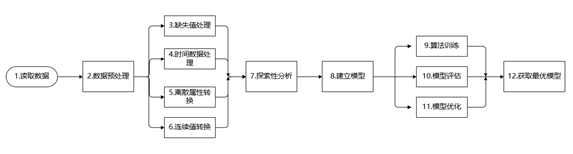

#### 实验介绍
违约预测只有违约和没有预约两种结果，是个二分类问题。针对二分类问题，可使用的算法有逻辑斯谛回归、朴素贝叶斯、支持向量机、树模型等。考虑到实验的完整性和实用性，本实验选用业界常用的逻辑斯谛回归（广义线性模型）和随机森林（集成树模型）来做对比。考虑到样本极度不均衡，模型评价选用综合指标f1_score。

In [2]:
##相关模块导入
###要求导入相关数据读取、处理、分析、可视化，算法模块等
import pandas as pd
import numpy as np
#导入相关包
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
##读取数据
path1=r"dataset-credit-default.csv"
df = pd.read_csv(path1,encoding='utf-8')

In [4]:
##读取数据
df.head()
df.shape

(6462, 34)

In [5]:
##查看Target的分布 ,是否违约（1是，0否）
df['Target'].value_counts()

0    6341
1     121
Name: Target, dtype: int64

In [6]:
#步骤 1	相关性分析,可视化观察特征相关性
#计算特征相关性
corr_matrix = df.corr(method='spearman')

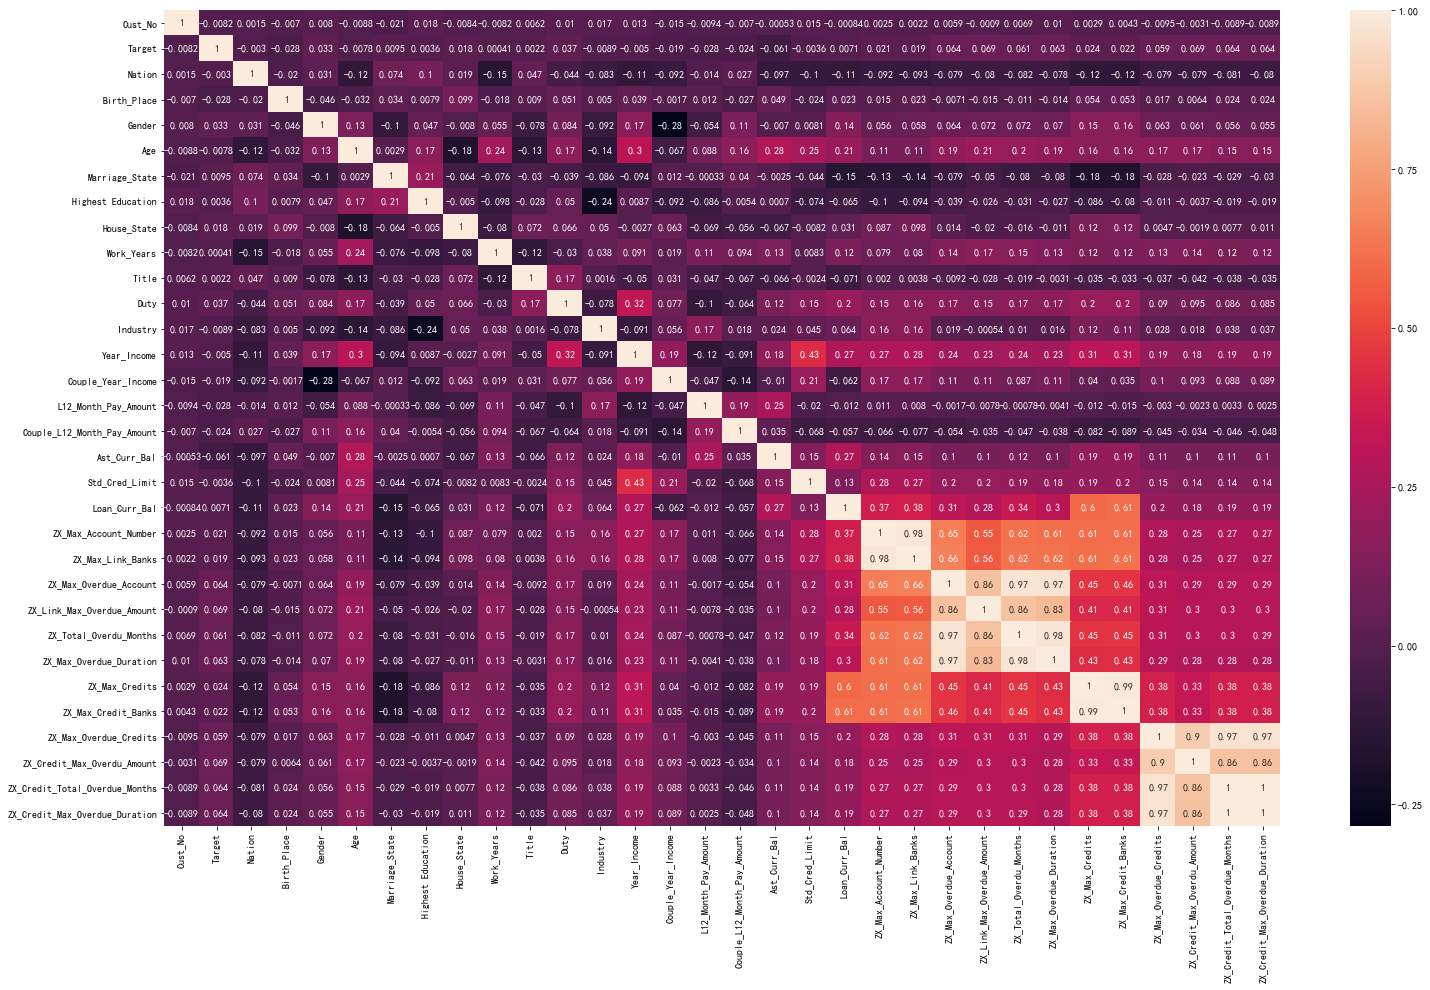

In [7]:
#可视化

plt.figure(figsize=(25, 15))
sns.heatmap(corr_matrix, annot= True)


In [8]:
#存储相关性过高的特征对,对于相关性过高的的特征，删除其中一个（根据工程经验，以0.8为界）：
# 选择出符合内容的单元格对应的行、列标签
cols_pair_to_drop = []
for index_ in corr_matrix.index:
    for col_ in corr_matrix.columns:
        if corr_matrix.loc[index_,col_] >= 0.8 and index_!=col_ and (col_,index_) not in cols_pair_to_drop:
            cols_pair_to_drop.append((index_,col_))
# print(cols_pair_to_drop)

In [9]:
#丢弃特征对中的一个
cols_to_drop = np.unique([col[1] for col in cols_pair_to_drop])  #对于一维数组或者列表，unique函数去除其中重复的元素，并按元素由大到小返回一个新的无元素重复的元组或者列表
df.drop(cols_to_drop,axis=1,inplace=True)
df.head()

,Cust_No,Target,Nation,Birth_Place,Gender,Age,Marriage_State,Highest Education,House_State,Work_Years,...,Couple_Year_Income,L12_Month_Pay_Amount,Couple_L12_Month_Pay_Amount,Ast_Curr_Bal,Std_Cred_Limit,Loan_Curr_Bal,ZX_Max_Account_Number,ZX_Max_Overdue_Account,ZX_Max_Credits,ZX_Max_Overdue_Credits
0,0,0,1.0,330621,1,41,20.0,61.0,NaN,0,...,20000.0,0.0,40013.0,1.82,5000,0.0,0,1,0,0
1,1,0,1.0,330621,1,41,20.0,71.0,1.0,0,...,500000.0,0.0,0.0,907.72,15000,900000.0,2,1,2,0
2,2,0,1.0,330621,1,55,40.0,71.0,1.0,0,...,180000.0,0.0,0.0,523.32,10000,560000.0,2,1,1,0
3,3,0,1.0,330621,1,41,20.0,61.0,1.0,68624,...,400000.0,0.0,0.0,4812.88,20000,1060000.0,1,0,1,0
4,4,0,1.0,330621,0,40,99.0,90.0,1.0,0,...,300000.0,0.0,0.0,2305.25,20000,0.0,4,0,0,0


##### 数值型变量异常值和缺失值处理

In [10]:
#打印出缺失率最高的前15个特征以及对应的缺失率
df_missing_stat = pd.DataFrame(df.isnull().sum()/df.shape[0],columns=['missing_rate']).reset_index()
df_missing_stat.sort_values(by='missing_rate',ascending=False)[:15]

,index,missing_rate
16,Couple_Year_Income,0.689260
18,Couple_L12_Month_Pay_Amount,0.689260
10,Unit_Kind,0.621634
11,Title,0.571804
14,Industry,0.564222
12,Occupation,0.555091
8,House_State,0.397864
2,Nation,0.330703
6,Marriage_State,0.309037
7,Highest Education,0.299133


可以看出缺失率最高的是Couple_Year_Income、Couple_L12_Month_Pay_Amount、Unit_Kind、Title、Industry和Occupation ，缺失率都超过了50%。其中，Couple_Year_Income和Couple_L12_Month_Pay_Amount是数值型变量；而Unit_Kind、Title、Industry和Occupation是名义型变量。

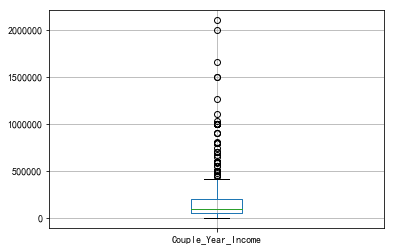

In [11]:
#针对Couple_Year_Income和Couple_L12_Month_Pay_Amount，需要先可视化来判定下如何填充。
df.boxplot(column=['Couple_Year_Income'])

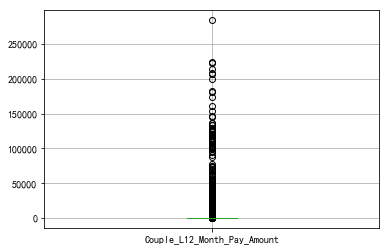

In [12]:
df.boxplot(column=['Couple_L12_Month_Pay_Amount'])

从上面箱图可以看出Couple_Year_Income和Couple_L12_Month_Pay_Amount异常值比例都不低，且缺失率很高，可以在删除带有异常值的样本的基础上，一般有两种选择：尝试用中位数（对数值型变量常用且在该业务场景下，使用中位数也符合实际的分布）来填充缺失值；或者直接删除。本实验尝试第一种。

In [13]:
#删除Couple_Year_Income的异常值并用中位数填补缺失值
item = 'Couple_Year_Income'
iqr = df[item].quantile(0.75) - df[item].quantile(0.25)
q_abnormal_L = df[item] < df[item].quantile(0.25) - 1.5 * iqr
q_abnormal_U = df[item] > df[item].quantile(0.75) + 1.5 * iqr
#取异常点的索引
print(item + '中有' + str(q_abnormal_L.sum() + q_abnormal_U.sum()) + '个异常值')
item_outlier_index = df[q_abnormal_L|q_abnormal_U].index

###删除异常值
df.drop(index = item_outlier_index,inplace=True)
print(df.shape)

#用中位数填补缺失值
df[item] = df[item].fillna(df[item].median())

#删除Couple_L12_Month_Pay_Amount的异常值并用中位数填补缺失值
item = 'Couple_L12_Month_Pay_Amount'
iqr = df[item].quantile(0.75) - df[item].quantile(0.25)
q_abnormal_L = df[item] < df[item].quantile(0.25) - 1.5 * iqr
q_abnormal_U = df[item] > df[item].quantile(0.75) + 1.5 * iqr
#取异常点的索引
print(item + '中有' + str(q_abnormal_L.sum() + q_abnormal_U.sum()) + '个异常值')
item_outlier_index = df[q_abnormal_L|q_abnormal_U].index
df.drop(index = item_outlier_index,inplace=True)
print(df.shape)
df[item] = df[item].fillna(df[item].median())


Couple_Year_Income中有131个异常值
(6331, 26)
Couple_L12_Month_Pay_Amount中有372个异常值
(5959, 26)


##### 名义型变量缺失值处理
名义型变量缺失值，Unit_Kind、Title、Industry和Occupation，先查看其分布。

1000    1802
1175     179
9999      63
2000      29
1172      16
1120       6
Be         1
ae         1
Da         1
Name: Unit_Kind, dtype: int64
9.0    1704
0.0     497
3.0      79
2.0      76
1.0      26
Name: Title, dtype: int64


(array([49.,  4.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  1. ,  79.8, 158.6, 237.4, 316.2, 395. , 473.8, 552.6, 631.4,
        710.2, 789. ]),
 <a list of 10 Patch objects>)

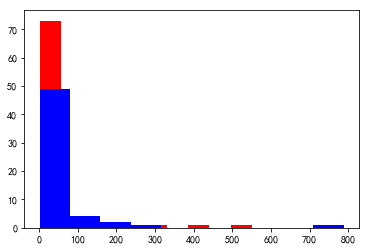

In [14]:
#工作单位性质
print(df['Unit_Kind'].value_counts())
#职务
print(df['Title'].value_counts())
#行业，取值较多，使用柱状图展示，用红色表示
plt.hist(df['Industry'].value_counts(),color='r')
#职务，取值较多，使用柱状图展示，用蓝色表示
plt.hist(df['Occupation'].value_counts(),color='b')

In [15]:
### 查看df中仍有少量缺失值的特征
null_col=[]
for col in df.columns:
    if df[col].isnull().sum()>0:
        null_col.append(col)
null_col

['Nation',
 'Marriage_State',
 'Highest Education',
 'House_State',
 'Unit_Kind',
 'Title',
 'Occupation',
 'Duty',
 'Industry']

In [16]:
###使用众数填充缺失值
for col_to_fill in null_col:
    df[col_to_fill] = df[col_to_fill].fillna(df[col_to_fill].mode()[0]) #选择每个特征出现频率对高的第一个属性值进行填充

In [17]:
### 删除无分类意义的特征列Cust_No
del df['Cust_No']

##### 对名义型变量做标签编码

In [18]:
### 查看数据集剩余的名称性特征
con_col=[]
for col in df.columns:
    if df.dtypes[col] == np.object:
        con_col.append(col)
con_col

['Unit_Kind', 'Occupation']

In [19]:
df['Unit_Kind'] = pd.factorize(df['Unit_Kind'])[0] 
df['Occupation'] = pd.factorize(df['Occupation'])[0] 

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5959 entries, 2 to 6460
Data columns (total 25 columns):
Target                         5959 non-null int64
Nation                         5959 non-null float64
Birth_Place                    5959 non-null int64
Gender                         5959 non-null int64
Age                            5959 non-null int64
Marriage_State                 5959 non-null float64
Highest Education              5959 non-null float64
House_State                    5959 non-null float64
Work_Years                     5959 non-null int64
Unit_Kind                      5959 non-null int64
Title                          5959 non-null float64
Occupation                     5959 non-null int64
Duty                           5959 non-null float64
Industry                       5959 non-null float64
Year_Income                    5959 non-null float64
Couple_Year_Income             5959 non-null float64
L12_Month_Pay_Amount           5959 non-null float64
Couple

#### 数据集划分
将数据集作9:1的切分（传统的使用二八分或者三七分，但此处样本量有5959条，测试集保留500多条就可以评价模型），训练集共5259条负样本，104条正样本；测试集共584条负样本，12条正样本。


In [21]:
x_cols = [col for col in df.columns if col!='Target']
y_col = 'Target'

In [22]:
from sklearn.model_selection import train_test_split
from collections import Counter
X_train, X_test, y_train, y_test = train_test_split(df[x_cols],
                    df[y_col],	
                    test_size=0.1, #分割比例
                    random_state=42, #随机数种子
                    shuffle=True, #是否打乱顺序 
     stratify=df[y_col])      #指定以Target的比例做分层抽样
print('Distribution of y_train {}'.format(Counter(y_train)))
print('Distribution of y_test {}'.format(Counter(y_test)))


Distribution of y_train Counter({0: 5259, 1: 104})
Distribution of y_test Counter({0: 584, 1: 12})


In [23]:
# 引入StandardScaler标准化工具库
from sklearn.preprocessing import StandardScaler
#对训练集和测试集做标准化
std_scaler = StandardScaler().fit(df[x_cols])
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)


#### 使用DT建模

In [25]:
#引入逻辑斯谛回归和特征选择的库
from sklearn import tree
#声明逻辑斯谛回归模型
clf = tree.DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X_train_std, y_train)
score = clf.score(X_test_std, y_test)

In [28]:
#特征重要性
clf.feature_importances_

array([0.00280801, 0.04837946, 0.01562074, 0.12494941, 0.02744519,
       0.02676454, 0.00463938, 0.01294467, 0.        , 0.00431963,
       0.0301933 , 0.03205294, 0.01203922, 0.09872751, 0.02630699,
       0.05317795, 0.        , 0.23043828, 0.04473802, 0.05526248,
       0.06956173, 0.04254609, 0.02726734, 0.00981711])

In [34]:
#predict返回每个测试样本的分类/回归结果
y_pre = clf.predict(X_test_std)

In [35]:
y_pre

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [36]:
#引入评价指标的库
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
print('accuracy of lr_model score',accuracy_score(y_test, y_pre))
print('f1_score of lr_model score',f1_score(y_test, y_pre))
print('recall_score of lr_model score',recall_score(y_test, y_pre))
print('precision_score of lr_model score',precision_score(y_test, y_pre))

accuracy of lr_model score 0.9614093959731543
f1_score of lr_model score 0.20689655172413793
recall_score of lr_model score 0.25
precision_score of lr_model score 0.17647058823529413


##### DT调参

In [44]:
from sklearn.model_selection import GridSearchCV
gini_thresholds = np.linspace(0,0.5,20)
parameters = {'splitter':('best','random')
,'criterion':("gini","entropy")
# ,"max_depth":[*range(1,10)]
# ,'min_samples_leaf':[*range(1,50,5)]
# ,'min_impurity_decrease':[*np.linspace(0,0.5,20)]
}
clf = tree.DecisionTreeClassifier(random_state=25)
GS = GridSearchCV(clf, parameters, cv=10)
GS.fit(X_train_std,y_train)
print(GS.best_params_)
print(GS.best_score_)

{'criterion': 'gini', 'splitter': 'best'}
0.9604698862576916


### 使用RandomForest建模

#### 不均衡样本处理：随机森林等带有样本权重调节参数的算法
一、class_weight :
分类模型中各种类型的权重，可以不输入，即不考虑权重，或者说所有类型的权重一样。

手动输入各个类型的权重：
比如对于0,1的二元模型，定义class_weight={0:0.8, 1:0.2}，即表示类型0的权重为80%，而类型1的权重为20%.
选择balanced：
类库根据训练样本量计算权重，表示样本数目越多，权重越小，样本数越少，权重越大。
计算方法如下：n_samples / (n_classes * np.bincount(y))
n_samples为样本数，n_classes为类别数量，np.bincount(y)会输出每个类的样本数，例如y=[1,0,0,0,0],则np.bincount(y)=[4,1]

什么场景下用class_weight?
(1) 误分类代价高：
如信用卡欺诈、乳腺癌检测等（将欺诈和阳性设为label 1），可适当提高label 1的权重
(2) 样本高度不平衡：
比如信用卡欺诈场景中，正常交易有280000次，欺诈有28次。如果不考虑权重，则将所有测试集都预测为正常交易，这样预测准确率理论上将大于99.99%，但是却没有任何意义。这时，可以选择balanced，让类库自动提高欺诈交易样本的权重。

样本高度不平衡的情况还可以考虑参数sample_weight
二、sample_weight (fit函数的参数)
当样本是高度失衡的，导致样本不是总体样本的无偏估计，从而可能导致模型预测能力下降。这种情况，可以通过调节样本权重来尝试解决这个问题。
调节样本权重的方法有两种：
（1）在class_weight使用balanced。
（2）调用fit函数时，通过sample_weight来调节每个样本权重。
在scikit-learn做逻辑回归时，如果上面两种方法都用到了，那么样本的真正权重是class_weight*sample_weight.

https://blog.csdn.net/weixin_43685844/article/details/88831907

In [45]:
### 先初始化几个参数拟合尝试下
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score,roc_auc_score,make_scorer,f1_score
from sklearn.model_selection import cross_val_score,GridSearchCV

#尝试使用100颗树，后续根据需要再降低树的数量
rf_model = RandomForestClassifier(class_weight='balanced',random_state=10)
rf_model.fit(X_train_std, y_train)
y_test_pred3 = rf_model.predict(X_test_std)
print('accuracy of rf_model score',accuracy_score(y_test, y_test_pred3))
print('f1_score of rf_model score',f1_score(y_test, y_test_pred3))
print('recall_score of rf_model score',recall_score(y_test, y_test_pred3))
print('precision_score of rf_model score',precision_score(y_test, y_test_pred3))


ImportError: cannot import name '_print_elapsed_time'

### 调参

In [30]:
### 对class_weight进行搜索
param_test0 = {'class_weight':[{0:1,1:3},{0:1,1:5},{0:1,1:10},{0:1,1:20},'balanced']}
gsearch0 = GridSearchCV(
    estimator = rf_model, 
    param_grid = param_test0, 
    cv=5
    )
gsearch0.fit(X_train_std,y_train)
print('best params:{}'.format(gsearch0.best_params_))
print('best score:{}'.format(gsearch0.best_score_))

best params:{'class_weight': {0: 1, 1: 20}}
best score:0.9809807943315308


In [31]:
### 对n_estimators进行搜索
param_test1 = {'n_estimators':range(10,101,10)}
gsearch1 = GridSearchCV(
    estimator = gsearch0.best_estimator_, 
    param_grid = param_test1, 
    cv=5
    )
gsearch1.fit(X_train_std,y_train)
print('best params:{}'.format(gsearch1.best_params_))
print('best score:{}'.format(gsearch1.best_score_))


best params:{'n_estimators': 10}
best score:0.9809807943315308


我们得到了最佳的决策树数，目前的随机森林有过拟合倾向，因为叶子最小样本数、最小分割样本数、最大深度等都是None，没有剪枝操作。

In [32]:
### 比较它与逻辑斯谛回归在测试集上的效果
y_test_final = gsearch1.best_estimator_.predict(X_test_std)
print('accuracy of rf_model score',accuracy_score(y_test, y_test_final))
print('f1_score of rf_model score',f1_score(y_test, y_test_final))
print('recall_score of rf_model score',recall_score(y_test,y_test_final))
print('precision_score of rf_model score',precision_score(y_test, y_test_final))

accuracy of rf_model score 0.9832214765100671
f1_score of rf_model score 0.2857142857142857
recall_score of rf_model score 0.16666666666666666
precision_score of rf_model score 1.0


随机森林在测试集上的准确率和f1等均比逻辑斯谛回归高一些，说明针对本数据集，随机森林比逻辑斯谛回归更适合。选择f1是希望模型尽量在精确率和召回率之间取得平衡，从业务角度看即在找出更多违约客户和避免误判之间的权衡。

#### 实验小结
本实验主要使用Python进行数据预处理、数据分析，使用seaborn做可视化分析，使用SMOTE方法来过采样，使用逻辑斯谛回归和随机森林建模，使用网格搜索来寻找最优参数组合。违约预测问题面临着所需数据维度多、正负样本严重不均衡等问题，在实际应用上，可以多搜集各类维度的特征，多尝试过采样、欠采样，也可以尝试使用无监督学习、深度神经网络等。